In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Bigger font
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')
# Figure size®
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 2.5
rcParams['lines.marker'] = '.'
rcParams['lines.linewidth'] = 1
rcParams['lines.markersize'] = 5
rcParams['legend.fontsize'] = 10
rcParams['axes.titlesize'] = 16
# plt.rc('figure.subplot', wspace=.33)
# Slides
from notebook.services.config import ConfigManager
cm = ConfigManager()
# cm.update('livereveal', {'width': 1024, 'height': 768, 'scroll': True, 'theme': 'simple', 'transition': 'linear'});
# np.random.seed(123)
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"  # print not only the last variable
%config InlineBackend.figure_format ='retina'  # retine quality plots

## Cartpole

Observation variables

```
Num	Observation	Min	Max
0	Cart Position	-2.4	2.4
1	Cart Velocity	-Inf	Inf
2	Pole Angle	  ~ -41.8°	~ 41.8°
3	Pole Velocity At Tip  -Inf	Inf
```

Actions

```
0	Push cart to the left
1	Push cart to the righ
```

## Logistic Policy 

The actions come from a policy

$$
\mathbf{a}_{t}=\pi\left(\mathbf{s}_{t}, \theta\right)
$$

where $t=\{1,\dots,T\}$. The parameter $\theta$ is part of the policy model that's assumed to be linear

$$
z = \theta_1 \text{p} + \theta_2 \text{v} + \theta_3 \text{a} + \theta_4 \text{tip}
$$

$$
P(Y = 1 | \mathbf{s}) = \frac{1}{1+ \exp(-z)}
$$

$$
\pi(\mathbf{s},\theta) = \text{round}(P(Y = 1 | \mathbf{s}))
$$

In [3]:
def model(state, theta):
    z = (np.dot(theta, state))
    model_action = 1 / (1 + np.exp(-z))
    return int(np.round(model_action))

state = np.array([0, 0, 15, 0])
theta = np.array([0.5, 0.5, 0.5, 0.5])
model(state, theta)

1

## GP & BO

In [4]:
class GP:
    """
    https://github.com/matthias-wright/sarcos/blob/master/models/gaussian_processes.py
    """
    
    def __init__(self, kernel, params):
        self.X_train = None
        self.Y_train = None
        self.kernel = kernel
        self.params = params
        pass
    
    def fit(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        return

    def draw_from_prior(self, X_test, num_samples):
        """
        Returns samples drawn from the prior distribution at the test inputs.
        :param num_samples: number of samples to be drawn
        :return: samples
        """
        K__star_star = GaussianProcess.RBF(X_test, X_test, self.params)
        return np.dot(K__star_star, np.random.normal(size=(len(X_test), num_samples)))

    def draw_from_posterior(self, X_test, num_samples):
        """
        Returns samples drawn from the posterior at the test inputs.
        :param num_samples: number of samples to be drawn
        :return: samples
        """
        K = GaussianProcess.RBF(self.X_train, self.X_train, self.params)
        ## Moore-Penrose) pseudo-inverse of a matrix.
        K_inverse = np.linalg.pinv(K)
#         K_inverse = np.linalg.inv(K)
        K__star_star = GaussianProcess.RBF(X_test, X_test, self.params)
        K_star_ = GaussianProcess.RBF(X_test, self.X_train, self.params)
        K__star = GaussianProcess.RBF(self.X_train, X_test, self.params)
        K_conditioned = K__star_star - np.dot(np.dot(K_star_, K_inverse), K__star)
        mu = np.dot(np.dot(K_star_, K_inverse), self.Y_train)
        return mu + np.dot(K_conditioned, np.random.normal(size=(len(X_test), num_samples)))

    def predict(self, X_test, return_std=True):
        """
        Predicts the output values for the provided inputs.
        :return: predictions, variance for the predictions
        """
        K = GP.RBF(self.X_train, self.X_train, self.params)
        ## Moore-Penrose) pseudo-inverse of a matrix.
        K_inverse = np.linalg.pinv(K)
#         K_inverse = np.linalg.inv(K)
        K__star_star = GP.RBF(X_test, X_test, self.params)
        K_star_ = GP.RBF(X_test, self.X_train, self.params)
        K__star = GP.RBF(self.X_train, X_test, self.params)
        K_conditioned = K__star_star - np.dot(np.dot(K_star_, K_inverse), K__star)
        sigma_squared = np.diag(K_conditioned)
        mu = np.dot(np.dot(K_star_, K_inverse), self.Y_train)
        
        if return_std:
            return mu, sigma_squared
        return mu

    def predict_cholesky(self, X_test, return_std=True):
        """
        Predicts the output values for the provided inputs. Uses the Cholesky decomposition (more on that in the report)
        in order to reduce computation and improve numerical stability.
        :return: predictions, variance for the predictions
        """
        K = GP.RBF(self.X_train, self.X_train, self.params)
        L = np.linalg.cholesky(K)
        K_star_ = GP.RBF(X_test, self.X_train, self.params)
        v = np.linalg.solve(L, self.Y_train)
        w = np.linalg.solve(L.T, v)
        mu = np.dot(K_star_, w)
        q = np.linalg.solve(L, K_star_.T)
        z = np.linalg.solve(L.T, q)
        K__star_star = GP.RBF(X_test, X_test, self.params)
        K_conditioned = K__star_star - np.dot(K_star_, z)
        sigma_squared = np.diag(K_conditioned)
        
        if return_std:
            return mu, sigma_squared
        return mu

    def test(self, X_test, Y_test, use_cholesky=False):
        """
        Tests the algorithm on the provided test set.
        :param use_cholesky: True: use Cholesky decomposition for computation, False: do not
        :return: RMSE for the test set, predictions on the test set, variance for the predictions
        """
        if use_cholesky:
            mu, sigma = self.predict_cholesky(X_test, self.params)
        else:
            mu, sigma = self.predict(X_test, self.params)
        rmse = np.sqrt(np.mean(np.square(mu - Y_test)))
        return rmse, mu, sigma

    @staticmethod
    def RBF(x1, x2, params): # TODO
        """
        Returns the covariance matrix according to the squared exponential kernel between x1 and x2.
        :return: Covariance matrix
        """
        dist = np.sum(x1**2, axis=1, keepdims=True) + np.sum(x2**2, axis=1) - 2 * np.dot(x1, x2.T)
        return params[0]**2 * np.exp(-(1 / (2 * params[1]**2)) * dist)
    
    
from scipy import optimize

class BayesianOptimization:
    """ Same but simplistic GPyOpt's BayesianOptimization implementation
    """
    
    def __init__(self, f, domain, model_type, acquisition_type):
        self.f = f
        
        self.X_sample = []
        self.Y_sample = []
        self.domain = np.array([d['domain'] for d in domain])
        
        ## Surrogate Model
        if model_type is 'GP':
            # RBF Kernel
            self.model_type = GP(GP.RBF, params=[1, 0.2]) # TODO
            
        ## Acquisition Function
        if acquisition_type is 'UCB':
            def ucb(X, X_sample, Y_sample, surrogate, balance=0.8):
                mu, variance = surrogate.predict(X, return_std=True)
                return mu + balance * variance    
            def obj(X):
                # Minimization objective is the negative acquisition function
                x_new = np.array([X])
                return ucb(x_new, self.X_sample, self.Y_sample, surrogate=self.model_type)
            self.acquisition_type = obj
        pass
    
    def run_optimization(self, max_iter):
        
        initial_design_numdata = 1
        for i in range(initial_design_numdata):
            x0 = [np.random.uniform(d[0], d[1]) for d in self.domain]
            X_next = np.array([x0])
            Y_next = self.f(X_next)
            # Add sample to initial samples
            self.X_sample = np.append(self.X_sample, X_next)
            self.Y_sample = np.append(self.Y_sample, Y_next)
        print("Initialized")
        self.X_sample = np.array([self.X_sample])
        self.Y_sample = np.array([self.Y_sample])
    
        for i in range(max_iter):
            self.model_type.fit(self.X_sample, self.Y_sample)

            # Minimize and obtain next sampling point
            ### Minimize brute force
#             output = optimize.brute(self.acquisition_type, self.domain)
#             X_next = np.array([output])

            ### Minimize default
            x0 = np.array([[np.random.uniform(d[0], d[1]) for d in self.domain]])
            output = optimize.minimize(self.acquisition_type, x0=x0, bounds=self.domain).x
            X_next = np.array([output])
            
            # print(output)
            
            # Obtain next sample from the objective function
            Y_next = self.f(X_next)
            # print("x = {}, y = {}".format(X_next, Y_next))

            # Add sample to previous samples
            self.X_sample = np.concatenate((self.X_sample, X_next), axis=0)
            self.Y_sample = np.append(self.Y_sample, Y_next)
    def get_evaluations(self):
        return self.X_sample, self.Y_sample

## SIMULATOR

In [5]:
import GPyOpt

TIME_LIMIT = 500

def run_simulation(env, theta, trace=True, render=False):
    print(theta)
    theta = theta[0]
    env.seed(0)
    observation = env.reset()
    
    state = []
    action = []
    frames = []
    cumulative_reward = 0
    for i in range(0, TIME_LIMIT):
        # Calculate the action
        model_action = model(observation, theta)
        
        # Save current state + action
        state.append(observation)
        action.append(model_action)
        # Execute action
        observation, reward, done, info = env.step(model_action)
        if render:
            frames.append(env.render(mode='rgb_array'))
            
        cumulative_reward += reward
        if done:
            state.append(observation)
            break
    if trace:
        print("Cumulative Reward:", cumulative_reward, "$theta:",theta)
    return cumulative_reward, state, action, frames


import gym
env = gym.make("CartPole-v0")

In [6]:
domain= [{'name':'position', 'type':'continuous', 'domain':(-2.4, 2.4)},
         {'name':'velocity', 'type':'continuous', 'domain':(-30, 30)},
         {'name':'angle', 'type':'continuous', 'domain':(-41.8, 41.8)},
         {'name':'tipvelocity', 'type':'continuous', 'domain':(-30, 30)},
         ]

f = lambda theta: run_simulation(env, theta, True, False)[0]  # output the cost

optimizer = BayesianOptimization(f=f, domain=domain, model_type='GP', acquisition_type ='UCB')
optimizer.run_optimization(max_iter=30)

[[ -1.94262316 -17.98190658 -29.89969809 -12.32160176]]
Cumulative Reward: 9.0 $theta: [ -1.94262316 -17.98190658 -29.89969809 -12.32160176]
Initialized
[[ 1.77015407 24.64355888 31.77555318 13.83066696]]
Cumulative Reward: 10.0 $theta: [ 1.77015407 24.64355888 31.77555318 13.83066696]
[[  1.88919676 -17.56292023 -22.20257391  11.69415442]]
Cumulative Reward: 35.0 $theta: [  1.88919676 -17.56292023 -22.20257391  11.69415442]
[[ -1.15426398 -28.67259479  30.03427206 -14.12554047]]
Cumulative Reward: 28.0 $theta: [ -1.15426398 -28.67259479  30.03427206 -14.12554047]
[[ -1.95131617  -0.73716785  -1.22296297 -19.4889908 ]]
Cumulative Reward: 10.0 $theta: [ -1.95131617  -0.73716785  -1.22296297 -19.4889908 ]
[[ 1.73513206 23.56478235  0.78283093 17.43916767]]
Cumulative Reward: 40.0 $theta: [ 1.73513206 23.56478235  0.78283093 17.43916767]
[[ -0.91876987 -29.88370159  27.25245608 -16.69620063]]
Cumulative Reward: 23.0 $theta: [ -0.91876987 -29.88370159  27.25245608 -16.69620063]
[[ -0.19791

In [7]:
a, b = optimizer.get_evaluations()
best_index = np.argmax(b)
best_x = np.reshape(a[best_index], (1, -1))
best_y = b[best_index]
print("Best parameters:", best_x, "Cum. Reward:",best_y)

Best parameters: [[-1.03913074  4.52593979 22.82047657 27.66799154]] Cum. Reward: 200.0


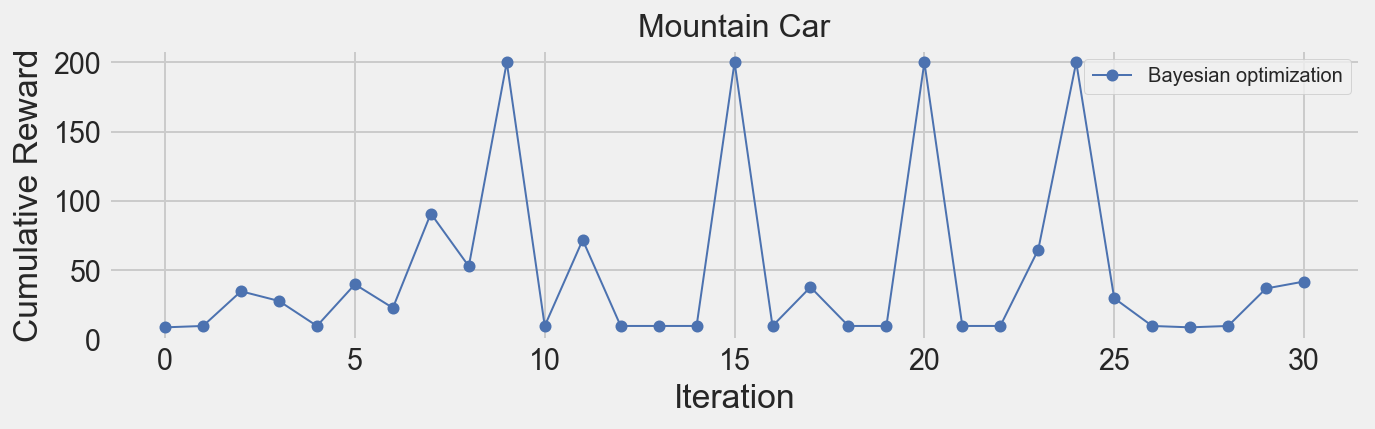

In [8]:
plt.plot(optimizer.Y_sample, 'bo-', label='Bayesian optimization');
plt.xlabel('Iteration');
plt.ylabel('Cumulative Reward');
plt.title('Mountain Car');
plt.legend();
# f.savefig("boiterations.pdf", bbox_inches='tight');

In [9]:
env.close()